In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [29]:
data = pd.read_csv('data/standardized_data.csv')

In [36]:
data

,Unnamed: 0,price,freight_value,payment_installments,payment_value,high_review_or_not,deliver_duration,deliver_estimated_duration,real_date_difference,customer_review_count,product_count
0,0,-0.689547,-1.099133,-0.333333,-0.700324,1,-0.777778,-0.9,-0.1,0.0,-0.26087
1,1,1.865302,0.214374,-0.333333,1.230907,1,0.555556,-0.2,-0.6,0.0,-0.26087
2,2,0.052802,-1.045849,-0.333333,-0.159838,1,-0.888889,-1.5,-0.6,0.0,-0.26087
3,3,0.403017,-0.832714,0.000000,0.106974,0,-0.777778,-1.9,-1.1,0.0,-0.26087
4,4,-0.398707,-0.987608,0.666667,-0.482866,1,-0.888889,-0.9,0.0,0.0,-0.26087
...,...,...,...,...,...,...,...,...,...,...,...
104209,104209,-0.484914,-0.018587,-0.333333,-0.125531,0,0.222222,0.6,0.5,1.0,0.00000
104210,104210,-0.484914,0.869888,-0.333333,0.400920,1,0.777778,0.6,0.0,2.0,0.00000
104211,104211,-0.484914,0.869888,-0.333333,0.400920,1,0.777778,0.6,0.0,2.0,0.00000
104212,104212,-0.484914,0.869888,-0.333333,0.400920,1,0.777778,0.6,0.0,2.0,0.00000


In [13]:
continuous_vs = ['price', 'freight_value', 'payment_installments', 'payment_value', 'deliver_duration', 'deliver_estimated_duration', 'real_date_difference', 'customer_review_count', 'product_count']
discrete_vs = ['payment_boleto','payment_credit_card','payment_debit_card','payment_voucher']

<AxesSubplot:>

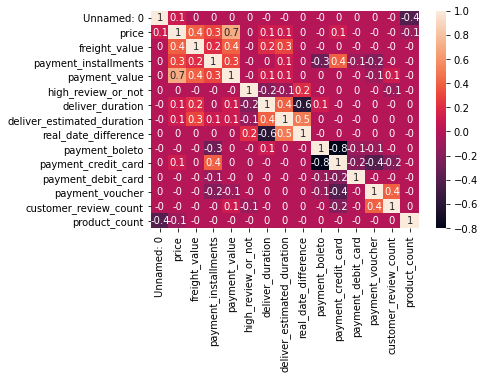

In [14]:
# create a correlation matrix rounding to one decimal point
correlation_matrix = data.corr().round(1)
# print a correlation heat map
sns.heatmap(data=correlation_matrix, annot=True)

In [37]:
y_data = data['high_review_or_not']
x_data = data.drop(['Unnamed: 0', 'high_review_or_not'], axis=1)
y_data.value_counts()

1    59583
0    44631
Name: high_review_or_not, dtype: int64

In [38]:
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.2)
# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(83371, 9)
(20843, 9)
(83371,)
(20843,)


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = [{'n_estimators': [10, 20],
                     'criterion': ['gini', 'entropy'],
                     'max_depth': [3, 5],
                     'max_features': ['sqrt', 'log2', None],
                     'class_weight': ['balanced', None]
                     }]

scores = ['f1_macro']

for score in scores:
    print("# Tuning hyperparameters for %s" % score)
    print("\n")
    rfc = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring=score)
    rfc.fit(X_train, Y_train)
    print("Best parameters set found on the training set:")
    print(rfc.best_params_)
    print("\n")

KeyboardInterrupt: 

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=5, max_features='sqrt', min_samples_split=5, n_estimators=20)
forest_model_fit = forest_model.fit(X_train, Y_train)

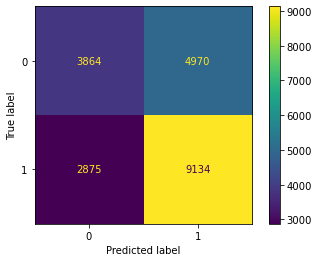

In [40]:
# predict the data
forest_predict = forest_model_fit.predict(X_test)

# build a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# see 
cm = confusion_matrix(Y_test, forest_predict, labels=forest_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=forest_model.classes_)

disp.plot()
plt.show()

In [41]:
from sklearn.metrics import accuracy_score, f1_score

# calculate metrics
acc = accuracy_score(Y_test, forest_predict)
f1_mac = f1_score(Y_test, forest_predict, average='macro')

# prnt results
print(f'RandomForest accuracy = {round(acc,2)}%')
print(f'RandomForest F1 score = {round(f1_mac,2)}')

RandomForest accuracy = 0.62%
RandomForest F1 score = 0.6


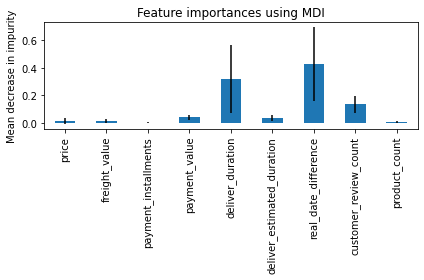

In [42]:
from sklearn import tree
import numpy as np
import time

importances = forest_model_fit.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_model_fit.estimators_], axis=0)

import pandas as pd

feature_names = X_train.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()